In [ ]:
"""Subtractive Clustering Algorithm
"""
__author__ = 'Daniel Albornoz'


import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial import distance_matrix

def subclust2(data, Ra, Rb=0, AcceptRatio=0.3, RejectRatio=0.1):
    if Rb==0:
        Rb = Ra*1.15
        
    scaler = MinMaxScaler()
    scaler.fit(data) 
    ndata = scaler.transform(data)
    
    # 14/05/2020 cambio list comprehensions por distance matrix
    #P = np.array([np.sum([np.exp(-(np.linalg.norm(u-v)**2)/(Ra/2)**2) for v in ndata]) for u in ndata])
    #print(P)
    P = distance_matrix(ndata,ndata)
    alpha=(Ra/2)**2
    P = np.sum(np.exp(-P**2/alpha),axis=0)
   
    centers = []
    i=np.argmax(P)
    C = ndata[i]
    p=P[i]
    centers = [C]
    
    continuar=True
    restarP = True
    while continuar:
        pAnt = p
        if restarP:
            P=P-p*np.array([np.exp(-np.linalg.norm(v-C)**2/(Rb/2)**2) for v in ndata])            
        restarP = True  
        i=np.argmax(P)
        C = ndata[i]
        p=P[i]
        if p>AcceptRatio*pAnt:
            centers = np.vstack((centers,C))
        elif p<RejectRatio*pAnt:
            continuar=False
        else: 
            dr = np.min([np.linalg.norm(v-C) for v in centers])
            if dr/Ra+p/pAnt>=1:
                centers = np.vstack((centers,C))
            else:
                P[i]=0
                restarP = False
        if not any(v>0 for v in P):
            continuar = False
    distancias = [[np.linalg.norm(p-c) for p in ndata] for c in centers]
    labels = np.argmin(distancias, axis=0)
    centers = scaler.inverse_transform(centers)
    return labels, centers



In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Wed May  6 17:56:16 2020

@author: Daniel Albornoz

Implementación similar a genfis2 de Matlab.
Sugeno type FIS. Generado a partir de clustering substractivo.

"""
__author__ = 'Daniel Albornoz'

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import time

def gaussmf(data, mean, sigma):
    return np.exp(-((data - mean)**2.) / (2 * sigma**2.))
    
class fisRule:
    def __init__(self, centroid, sigma):
        self.centroid = centroid
        self.sigma = sigma
    
class fisInput:
    def __init__(self, min,max, centroids):
        self.minValue = min
        self.maxValue = max
        self.centroids = centroids

    
    def view(self):
        x = np.linspace(self.minValue,self.maxValue,20)
        plt.figure()
        for m in self.centroids:
            s = (self.minValue-self.maxValue)/8**0.5
            y = gaussmf(x,m,s)
            plt.plot(x,y)
        
class fis:
    def __init__(self):
        self.rules=[]
        self.memberfunc = []
        self.inputs = []
        
   
    
    def genfis(self, data, radii):

        start_time = time.time()
        labels, cluster_center = subclust2(data, radii)
        
        #print("--- %s seconds ---" % (time.time() - start_time))
        n_clusters = len(cluster_center)
        
        cluster_center = cluster_center[:,:-1]
        P = data[:,:-1]
        #T = data[:,-1]
        maxValue = np.max(P, axis=0)
        minValue = np.min(P, axis=0)       
     
        self.inputs = [fisInput(maxValue[i], minValue[i],cluster_center[:,i]) for i in range(len(maxValue))]
        self.rules = cluster_center
        self.entrenar(data)

    def entrenar(self, data):
        P = data[:,:-1]
        T = data[:,-1]
        #___________________________________________
        # MINIMOS CUADRADOS (lineal)
        sigma = np.array([(i.maxValue-i.minValue)/np.sqrt(8) for i in self.inputs])
        f = [np.prod(gaussmf(P,cluster,sigma),axis=1) for cluster in self.rules]
        
        nivel_acti = np.array(f).T
        #print("nivel acti")
        #print(nivel_acti)
        sumMu = np.vstack(np.sum(nivel_acti,axis=1))
        #print("sumMu")
        #print(sumMu)
        P = np.c_[P, np.ones(len(P))]
        n_vars = P.shape[1]
        
        orden = np.tile(np.arange(0,n_vars), len(self.rules))
        acti = np.tile(nivel_acti,[1,n_vars])
        inp = P[:, orden]
        
        
        A = acti*inp/sumMu
        
        # A = np.zeros((N, 2*n_clusters))
        # for jdx in range(n_clusters):
        #     for kdx in range(nVar):
        #         A[:, jdx+kdx] = nivel_acti[:,jdx]*P[:,kdx]/sumMu
        #         A[:, jdx+kdx+1] = nivel_acti[:,jdx]/sumMu
        
        b = T

        solutions, residuals, rank, s = np.linalg.lstsq(A,b,rcond=None)
        self.solutions = solutions #.reshape(n_clusters,n_vars)
        #print(solutions)
        return 0

    def evalfis(self, data):
        sigma = np.array([(input.maxValue-input.minValue) for input in self.inputs])/np.sqrt(8)
        f = [np.prod(gaussmf(data,cluster,sigma),axis=1) for cluster in self.rules]
        nivel_acti = np.array(f).T
        sumMu = np.vstack(np.sum(nivel_acti,axis=1))
         
        P = np.c_[data, np.ones(len(data))]
        
        n_vars = P.shape[1]
        n_clusters = len(self.rules)
        
        orden = np.tile(np.arange(0,n_vars), n_clusters)
        acti = np.tile(nivel_acti,[1,n_vars])
        inp = P[:, orden]
        coef = self.solutions
        
        return np.sum(acti*inp*coef/sumMu,axis=1)
        
    
    def viewInputs(self):
        for input in self.inputs:
            input.view()

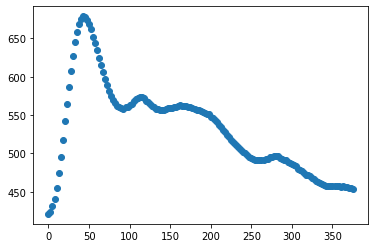

In [ ]:
df = pd.read_csv('samplesVDA1.txt', header = None)
datos = np.array(df)
y = np.array(datos[:,0])
x = []
cont=0
for i in y:
  x.append(cont * 2.5)
  cont+=1
datos = np.array([x,y]).transpose()
plt.scatter(datos[:,0],datos[:,1])

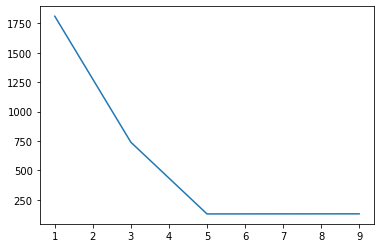

In [ ]:
v_errors = []
v_choose = []

fis2 = fis()

pruebas = np.array([1.4 ,1.1, 0.7, 0.4]) #Vector con los distintos radios con los que ejecutaremos sugeno

for prueba in pruebas:
  fis2.genfis(datos, prueba) #Entrenamos con los datos al modelo
  r = fis2.evalfis(np.vstack(x)) #Utilizamos el modelo entrenado con los datos que tenia en X
  v_errors.append(np.sum((y - r)**2)/len(x)) #Calculamos el error

rules=[1,3,5,9] #Graficamente vemos la cantidad de reglas para cada modelo

plt.plot(rules,v_errors)

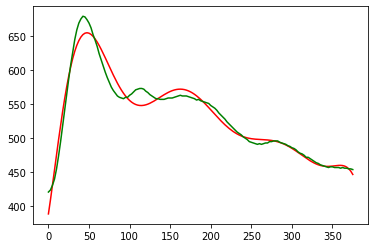

In [ ]:
v_choose = np.divide(v_errors, rules)#Para tener una idea de los errores segun la cantidad de reglas
#Utilizamos un modelo con 5 reglas, es decir con radio = 0.7

fis2.genfis(datos, 0.7)
r = fis2.evalfis(np.vstack(x))
v_errors.append(np.sum((y - r)**2)/len(x))

plt.plot(datos[:,0],r,color='r')
plt.plot(datos[:,0],datos[:,1],color='g')
#En rojo graficamos el modelo
#En verde graficamos la data extraida

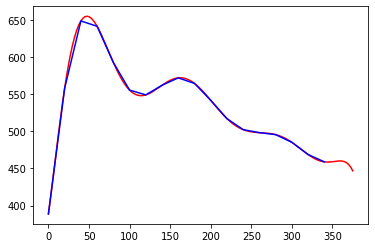

In [ ]:
v_sobremuestreo = np.arange(0,351,20)
fis2.genfis(datos, 0.7)
r_sobremuestreo = fis2.evalfis(np.vstack(v_sobremuestreo))
plt.plot(datos[:,0],r,color='r')
plt.plot(v_sobremuestreo,r_sobremuestreo,color='b')